# Reconstruction of the frequency using spatial mapping 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE
from qnmfits.spatial_mapping_functions import *
from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D

plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

In [2]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_options = [("Lev4", "R2"), ("Lev4", "R3"), ("Lev5", "R3")]

sims = []

for lev, R in sim_options:
    try:
        sim = CCE.SXS_CCE(id, lev=lev, radius=R)
        sims.append(sim)
    except:
        pass

In [3]:
l_max = 8
n_max = 7

In [4]:
tstart = -30
tend = 101
tstep = 1

times_list = np.arange(tstart, tend, tstep)

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi / 2, np.pi / 2, 200)
Lon, Lat = np.meshgrid(lon, lat)

mappings = [
    [(2, 2, 0, 1)],
    [(3, 2, 0, 1)],
    [(4, 4, 0, 1)],
    [(5, 4, 0, 1)],
    [(6, 6, 0, 1)],
]

arg_list = np.zeros((len(mappings), len(times_list)))
oarg_list = np.zeros((len(mappings), len(sims), len(times_list)))

for j, mapping in enumerate(mappings):

    map = mapping[0]
    lp, mp, npp, pp = map

    QNMs = [(lam, mp, n, p) for lam in np.arange(mp, l_max + 1) for n in np.arange(0, n_max + 1) for p in (-1, +1)]

    for i, step in enumerate(times_list):
        best_fit = mapping_multimode_ringdown_fit(
            sim_main.times,
            sim_main.h,
            modes=QNMs,
            Mf=sim_main.Mf,
            chif=sim_main.chif_mag,
            t0=step,
            mapping_modes=mapping,
            spherical_modes=[(lam, mp) for lam in np.arange(mp, l_max + 1)],
        )

        _, arg, _ = spatial_mismatch_linear(best_fit, map, sim_main.chif_mag, l_max)
        arg_list[j][i] = arg

        for k, sim in enumerate(sims):

            best_fit_alt = mapping_multimode_ringdown_fit(
                sim.times,
                sim.h,
                modes=QNMs.copy(),
                Mf=sim.Mf,
                chif=sim.chif_mag,
                t0=step,
                mapping_modes=mapping,
                spherical_modes=[(lam, mp) for lam in np.arange(mp, l_max + 1)],
            )

            _, arg, _ = spatial_mismatch_linear(best_fit_alt, map, sim_main.chif_mag, l_max)
            oarg_list[j][k][i] = arg

In [5]:
reconstruction_times = [19, 24.676, 30.352, 36.028]

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi / 2, np.pi / 2, 200)
Lon, Lat = np.meshgrid(lon, lat)

F_mapping = [(2, 2, 0, 1)]

map = F_mapping[0]
lp, mp, npp, pp = map

QNMs = [(lam, mp, n, p) for lam in np.arange(mp, l_max + 1) for n in np.arange(0, n_max + 1) for p in (-1, +1)]

for i, step in enumerate(reconstruction_times):

    best_fit = mapping_multimode_ringdown_fit(
        sim_main.times,
        sim_main.h,
        modes=QNMs,
        Mf=sim_main.Mf,
        chif=sim_main.chif_mag,
        t0=step,
        mapping_modes=F_mapping,
        spherical_modes=[(lam, mp) for lam in np.arange(mp, l_max + 1)],
    )

    F = spatial_reconstruction(np.pi / 2 - Lat, Lon, best_fit, map, l_max)

    if step == reconstruction_times[0]:
        F1 = F
    elif step == reconstruction_times[1]:
        F2 = F
    elif step == reconstruction_times[2]:
        F3 = F
    elif step == reconstruction_times[3]:
        F4 = F

/tmp/ipykernel_1962708/3222088244.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", len(mappings))


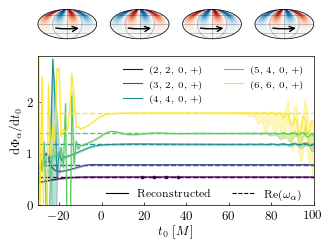

In [6]:
fig = plt.figure(figsize=(fig_width, fig_height * 1.5))
gs = fig.add_gridspec(2, 4)
axs_small = [fig.add_subplot(gs[0, i], projection="mollweide") for i in range(4)]
axs_large = [fig.add_subplot(gs[i + 1, :]) for i in range(1)]

colors = plt.cm.get_cmap("viridis", len(mappings))

xticks = np.radians([-180, -90, 0, 90, 180])
yticks = np.radians([-90, -45, 0, 45, 90])

for ax in axs_small:
    for x in xticks:
        ax.plot([x, x], [-np.pi / 2, np.pi / 2], color="k", linewidth=0.5, alpha=0.3)
    for y in yticks:
        ax.plot([-np.pi, np.pi], [y, y], color="k", linewidth=0.5, alpha=0.3)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.annotate(
        "",
        xy=(np.pi / 2, -np.pi * 0.1),
        xycoords="data",
        xytext=(-np.pi / 2, -np.pi * 0.1),
        textcoords="data",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.08", color="k"),
    )

axs_small[0].pcolormesh(Lon, Lat, np.real(F1), cmap=plt.cm.RdBu)
axs_small[1].pcolormesh(Lon, Lat, np.real(F2), cmap=plt.cm.RdBu)
axs_small[2].pcolormesh(Lon, Lat, np.real(F3), cmap=plt.cm.RdBu)
axs_small[3].pcolormesh(Lon, Lat, np.real(F4), cmap=plt.cm.RdBu)

for j, mapping in enumerate(mappings):

    uvsarg = UnivariateSpline(times_list, -np.unwrap(arg_list[j]), k=4, s=0)
    duvsarg = uvsarg.derivative()(times_list)
    axs_large[0].plot(
        times_list,
        duvsarg,
        color=colors(j),
        label=f"({mapping[0][0]}, {mapping[0][1]}, {mapping[0][2]}, +)",
    )  # TODO: Fix +) to be latex
    f_estimate = np.mean(uvsarg.derivative()(times_list[(times_list >= 0) & (times_list <= 50)]))
    f_actual = qnmfits.qnm.omega_list(mapping, sim_main.chif_mag, sim_main.Mf)
    axs_large[0].axhline(np.real(f_actual), color=colors(j), ls="--", lw=1)

    min_estimate = duvsarg
    max_estimate = duvsarg

    for k, sim in enumerate(sims):
        uvsarg = UnivariateSpline(times_list, -np.unwrap(oarg_list[j][k]), k=4, s=0)
        duvsarg = uvsarg.derivative()(times_list)
        min_estimate = np.minimum(min_estimate, duvsarg)
        max_estimate = np.maximum(max_estimate, duvsarg)

    axs_large[0].fill_between(times_list, min_estimate, max_estimate, color=colors(j), alpha=0.3)

    if mapping[0] == (2, 2, 0, 1):
        for i, step in enumerate(reconstruction_times):
            axs_large[0].plot(step, np.real(f_actual), marker="s", color=colors(j), markersize=2)

axs_large[0].set_xlim(-30, tend - 1)
axs_large[0].set_ylim(0, 2.9)

solid_line = Line2D([0], [0], color="black", linestyle="-")
dashed_line = Line2D([0], [0], color="black", linestyle="--")
color_legend = axs_large[0].legend(ncol=2, frameon=False, loc="upper right", fontsize=7, bbox_to_anchor=(1, 1))
line_legend = axs_large[0].legend(
    [solid_line, dashed_line],
    ["Reconstructed", r"$\mathrm{Re}(\omega_{\alpha})$"],
    frameon=False,
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.6, -0.03),
)
axs_large[0].add_artist(color_legend)

plt.xlabel("$t_0 \ [M]$")
axs_large[0].set_ylabel(r"$\mathrm{d}\Phi_{\alpha}/\mathrm{d}t_0$")
fig.savefig("figs/reconstruction_t0.pdf", bbox_inches="tight")
plt.show()